# House Price Regression
**Data: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview**

### Explore Data

In [733]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, mean_squared_error, r2_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [734]:
dataset = pd.read_csv('train.csv')
target = 'SalePrice'
df = dataset.drop(labels =[target, 'Id'], axis=1)
targets = dataset[target]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

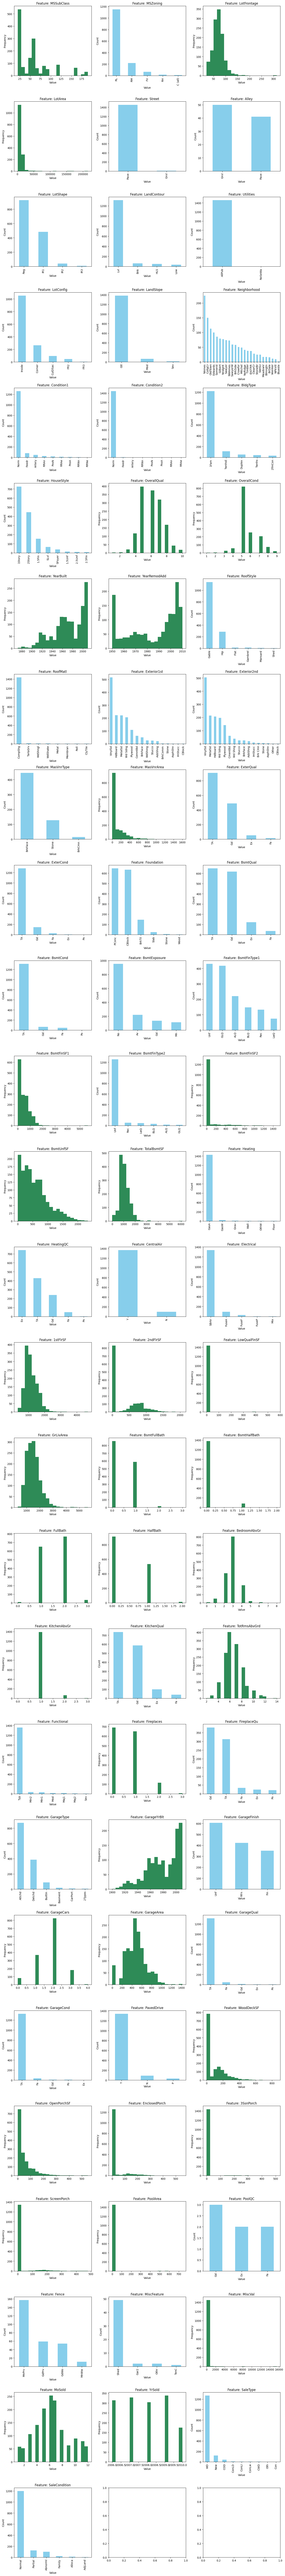

In [735]:
# Create subplots with 3 columns
num_columns = 3
num_rows = (len(df.columns) - 1) // num_columns + 1
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Plot each feature
for i, column in enumerate(df.columns):
    ax = axes[i // num_columns, i % num_columns]

    if df[column].dtype == 'object':
        # Plot histogram for categorical data
        df[column].value_counts().plot(kind='bar', stacked=True, ax=ax, color='skyblue')
        ax.set_ylabel('Count')
    else:
        # Plot histogram for numerical data
        df[column].plot(kind='hist', ax=ax, color='seagreen', bins=20)
        ax.set_ylabel('Frequency')

    ax.set_title(f'Feature: {column}')
    ax.set_xlabel('Value')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Preprocess

In [736]:
df[target] = targets

# Fill missing values
for column in df.columns:
    if df[column].dtype == 'object':
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

# One hot encoding categorical data
df = pd.get_dummies(df)

There are 44 out of 288 features with correlation index larger than 0.3:
Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Exterior1st_VinylSd',
       'Exterior2nd_VinylSd', 'MasVnrType_Stone', 'ExterQual_Ex',
       'ExterQual_Gd', 'ExterQual_TA', 'Foundation_CBlock', 'Foundation_PConc',
       'BsmtQual_Ex', 'BsmtQual_TA', 'BsmtExposure_Gd', 'BsmtExposure_No',
       'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'HeatingQC_TA', 'KitchenQual_Ex',
       'KitchenQual_Gd', 'KitchenQual_TA', 'GarageType_Detchd',
       'GarageFinish_Fin', 'GarageFinish_Unf', 'SaleType_New',
       'SaleCondition_Partial'],
      dtype='object')


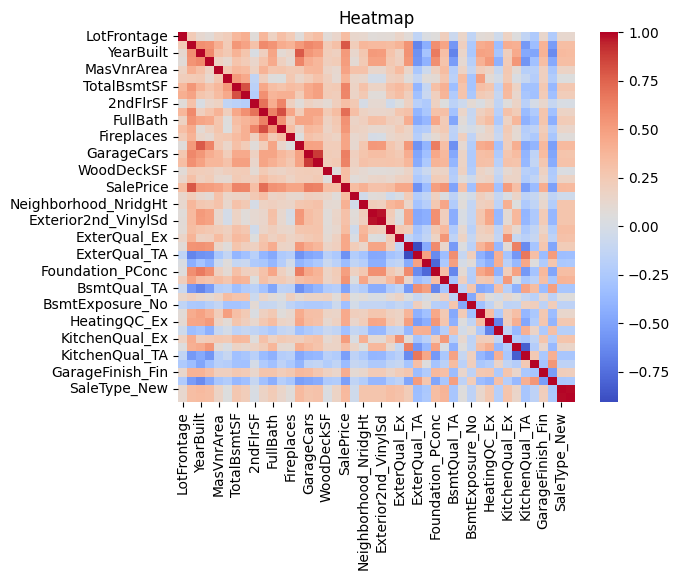

In [737]:
# Remove uncorrelated features to reduce training time
corr_threshold = 0.3
all_corr = df.corr()
corr_features = all_corr[target][(all_corr[target] > corr_threshold) | (all_corr[target] < -1 * corr_threshold)].index
df = df[corr_features]

print(f"There are {len(corr_features)} out of {len(all_corr[target])} features with correlation index larger than {corr_threshold}:")
print(corr_features)

# Correlation heatmap
correlation = df.corr()
sns.heatmap(correlation, cmap='coolwarm')
plt.title('Heatmap')
plt.show()

## Linear Regression

In [738]:
# Split data
y = df[target]
X = df.drop(labels =[target],axis=1)
X_train, X_test, Y_train, Y_test = train_test_split( X , y , test_size = 0.2, random_state = 42)

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [739]:
# Linear Regression
sklreg = linear_model.LinearRegression()
sklreg.fit(X_train, Y_train)
Y_pred = sklreg.predict(X_test)

In [740]:
# Evaluate
print("R-Squared:", r2_score(Y_test, Y_pred))

R-Squared: 0.8600863366225038


## Logistic Regression

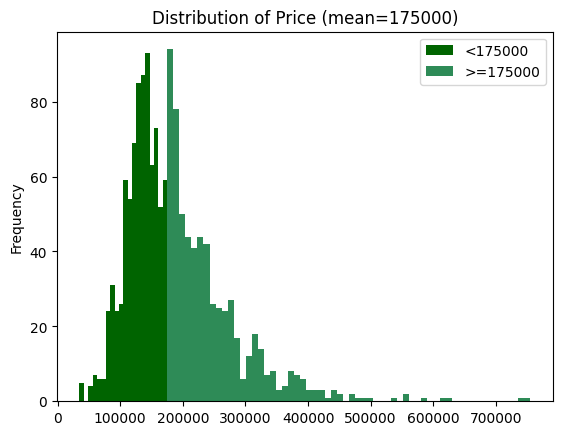

In [741]:
# Display how the continuous target will be split
threshold = 175_000

df[target][df[target] < threshold].plot(kind='hist', color='darkgreen', bins=20, label=f'<{threshold}')
df[target][df[target] >= threshold].plot(kind='hist', color='seagreen', bins=60, label=f'>={threshold}')
plt.title(f"Distribution of Price (mean={threshold})")
plt.legend()
plt.show()

In [742]:
# Change target to a binary classification instead of continuous value
df['Label'] = (df[target] > threshold).astype(int)

# Split data
y = df['Label']
X = df.drop(labels =['Label', target],axis=1)
X_train, X_test, Y_train, Y_test = train_test_split( X , y , test_size = 0.2, random_state = 42)

In [743]:
# Logistic Regression
logreg = linear_model.LogisticRegression(max_iter=10000)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

In [744]:
# Evaluate
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Report:\n", classification_report(Y_test, Y_pred))


Confusion Matrix:
 [[162  14]
 [  7 109]]
Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       176
           1       0.89      0.94      0.91       116

    accuracy                           0.93       292
   macro avg       0.92      0.93      0.93       292
weighted avg       0.93      0.93      0.93       292

